### 규칙 생성

In [ ]:
# -*- coding: utf-8 -*-
import os
import json
import csv
import re
import random
import ast
import time
from pathlib import Path
import google.generativeai as genai
from dotenv import load_dotenv

# --- 설정 ---
load_dotenv()
API_KEY = os.getenv("GOOGLE_API_KEY")
MODEL_NAME = "models/gemini-2.5-flash"

# 파일 경로 설정
try:
    ROOT_DIR = Path(__file__).resolve().parent
except NameError:
    ROOT_DIR = Path(os.getcwd())

# 🌟 gloss 폴더 안의 실제 파일명을 정확히 지정
CSV_PATH = ROOT_DIR / "gloss_dictionary_MOCK.csv"  # 사전 파일 (xlsx)
RULES_JSON_PATH = ROOT_DIR / "rules.json"           # 규칙 파일
TOKENS_PATH = ROOT_DIR / "gloss_tokens.txt"         # 대본에서 추출한 토큰
SCRIPT_PATH = ROOT_DIR / "script.txt"               # 전체 대본

def norm(s):
    return str(s).strip().replace(" ", "")

# 1. DB에 있는 모든 유효 단어(Key) 로드
def load_db_keys(csv_path):
    valid_keys = set()
    if not csv_path.exists():
        print("[Error] CSV 파일이 없습니다.")
        return valid_keys
    
    with open(csv_path, 'r', encoding='utf-8') as f:
        # csv 모듈 대신 직접 파싱 (korean_meanings 구조 때문)
        # pandas 없이 가볍게 처리
        lines = f.readlines()
        for line in lines[1:]: # 헤더 건너뜀
            # 단순 파싱: 대괄호 안의 내용 추출
            match = re.search(r"\[(.*?)\]", line)
            if match:
                content = match.group(1)
                # '파랑', '청' -> 파싱
                words = [w.strip().replace("'", "").replace('"', "") for w in content.split(',')]
                for w in words:
                    if w: valid_keys.add(w)
    return valid_keys

# 2. 토큰의 문맥(예시 문장) 찾기
def get_context_sentence(token, script_lines):
    # 해당 토큰이 포함된 문장 중 하나를 랜덤으로 반환 (너무 길면 앞부분만)
    candidates = [line.strip() for line in script_lines if token in line]
    if candidates:
        return random.choice(candidates)
    return "문맥 없음"

# 3. Gemini에게 매핑 요청
def ask_gemini_mapping(unknown_words_with_context):
    # unknown_words_with_context = [{"word": "...", "context": "..."}, ...]
    if not unknown_words_with_context:
        return {}

    genai.configure(api_key=API_KEY)
    model = genai.GenerativeModel(MODEL_NAME)
    
    prompt = f"""
    당신은 수어 번역 데이터 전처리 전문가입니다.
    아래 주어진 '단어(word)'들은 현재 수어 데이터베이스에 없는 단어들입니다.
    함께 제공된 '문맥(context)'을 보고, 이 단어를 **의미가 가장 유사한 '기초 단어'** 또는 **'기초 단어들의 조합'**으로 변환해주세요.

    [규칙]
    1. **Synonym(동의어):** 1:1로 대체 가능한 기초 명사/동사 (예: "수령" -> ["받다"])
    2. **Compound(복합어):** 의미 단위로 분해 (예: "우대금리" -> ["특별", "금리"])
    3. **Uncertain(불확실):** 도저히 기초 단어로 표현이 안 되거나, 사람의 확인이 꼭 필요한 경우 (예: 고유명사, 신조어) -> "targets": [] 로 비워둘 것.
    
    [입력 데이터]
    {json.dumps(unknown_words_with_context, ensure_ascii=False)}

    [출력 형식 - JSON Only]
    {{
      "results": [
        {{ "word": "수령", "targets": ["받다"], "type": "synonym" }},
        {{ "word": "우대금리", "targets": ["특별", "금리"], "type": "compound" }},
        {{ "word": "이상한단어", "targets": [], "type": "uncertain" }}
      ]
    }}
    """
    
    try:
        resp = model.generate_content(prompt, generation_config={"response_mime_type": "application/json"})
        return json.loads(resp.text).get("results", [])
    except Exception as e:
        print(f"[Error] Gemini API 호출 실패: {e}")
        return []

def main():
    # --- 데이터 로드 ---
    print("1. 데이터 로드 중...")
    db_keys = load_db_keys(CSV_PATH)
    print(f"   - DB 유효 키 개수: {len(db_keys)}")

    # rules.json 로드 (없으면 생성)
    if RULES_JSON_PATH.exists():
        with open(RULES_JSON_PATH, 'r', encoding='utf-8') as f:
            rules = json.load(f)
    else:
        rules = {"disambiguation_rules": {}, "fixed_mappings": {}, "word_substitution": {}, "manual_review_required": {}}
    
    # 누락된 필드 초기화
    if "word_substitution" not in rules: rules["word_substitution"] = {}
    if "manual_review_required" not in rules: rules["manual_review_required"] = {}

    # 대본 로드
    with open(SCRIPT_PATH, 'r', encoding='utf-8') as f:
        script_lines = f.readlines()

    # 토큰 로드
    with open(TOKENS_PATH, 'r', encoding='utf-8') as f:
        tokens = [line.strip() for line in f if line.strip()]

    # --- 처리 대상 필터링 ---
    target_tokens = []
    skipped_count = 0
    
    # 정규식: 숫자 포함, 혹은 1글자 특수문자 등 제외
    regex_skip = re.compile(r"[0-9]|[.,!?;:]")

    for t in tokens:
        # 1) 이미 DB에 있으면 패스
        if t in db_keys:
            continue
        # 2) 이미 규칙에 있으면 패스
        if t in rules["word_substitution"] or t in rules["manual_review_required"]:
            continue
        # 3) 숫자/특수문자 포함이면 패스 (이미지 처리 영역)
        if regex_skip.search(t):
            skipped_count += 1
            continue
            
        target_tokens.append(t)

    # 중복 제거
    target_tokens = sorted(list(set(target_tokens)))
    print(f"2. 분석 대상 미등재 단어: {len(target_tokens)}개 (숫자 등 제외됨: {skipped_count})")

    if not target_tokens:
        print("   - 처리할 단어가 없습니다. 종료합니다.")
        return

    # --- 배치 처리 (LLM) ---
    BATCH_SIZE = 20
    processed_count = 0
    auto_success = 0
    manual_flagged = 0

    print("3. LLM 분석 및 규칙 생성 시작...")
    
    for i in range(0, len(target_tokens), BATCH_SIZE):
        batch = target_tokens[i:i+BATCH_SIZE]
        batch_input = []
        
        # 문맥 매핑
        for token in batch:
            ctx = get_context_sentence(token, script_lines)
            batch_input.append({"word": token, "context": ctx})
        
        # LLM 호출
        print(f"   - Processing batch {i+1}/{len(target_tokens)}...")
        results = ask_gemini_mapping(batch_input)
        
        # 결과 검증 및 분류
        for res in results:
            word = res.get("word")
            targets = res.get("targets")
            
            if not targets: # LLM이 포기함 (Uncertain)
                rules["manual_review_required"][word] = {
                    "reason": "LLM Uncertain",
                    "context": get_context_sentence(word, script_lines)
                }
                manual_flagged += 1
                continue

            # 검증: Targets가 실제 DB에 있는가?
            all_valid = True
            invalid_parts = []
            for t_part in targets:
                if t_part not in db_keys:
                    all_valid = False
                    invalid_parts.append(t_part)
            
            if all_valid:
                # 성공 -> word_substitution에 추가
                rules["word_substitution"][word] = targets
                auto_success += 1
            else:
                # 실패 -> 사람이 봐야 함 (LLM이 없는 단어를 추천함)
                rules["manual_review_required"][word] = {
                    "reason": f"Target not in DB: {invalid_parts}",
                    "suggested": targets,
                    "context": get_context_sentence(word, script_lines)
                }
                manual_flagged += 1
                
        # API Rate Limit 고려 (필요시)
        time.sleep(1) 

    # --- 결과 저장 ---
    with open(RULES_JSON_PATH, 'w', encoding='utf-8') as f:
        json.dump(rules, f, ensure_ascii=False, indent=2)

    print("\n" + "="*40)
    print(f"[처리 결과 요약]")
    print(f"1. 총 분석 대상 : {len(target_tokens)} 개")
    print(f"2. 자동 해결    : {auto_success} 개 (word_substitution에 추가됨)")
    print(f"3. 수작업 필요  : {manual_flagged} 개 (manual_review_required에 추가됨)")
    print(f"   -> 경로: {RULES_JSON_PATH}")
    print("="*40)

if __name__ == "__main__":
    main()

1. 데이터 로드 중...
   - DB 유효 키 개수: 7741
2. 분석 대상 미등재 단어: 0개 (숫자 등 제외됨: 277)
   - 처리할 단어가 없습니다. 종료합니다.


d:\proj\py\signance\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 시각화

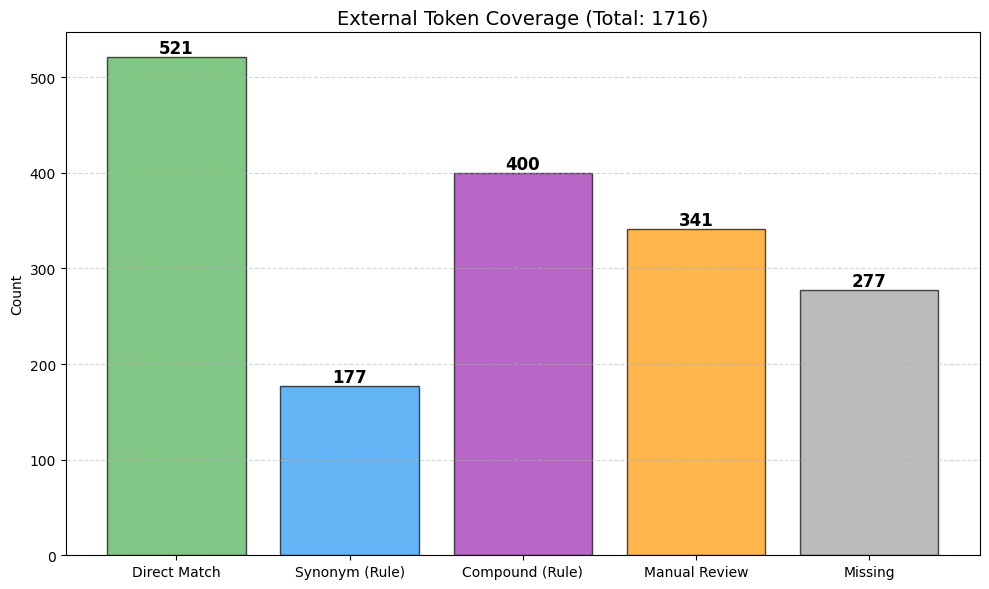

📊 [상세 수치]
 - Direct Match: 521
 - Synonym (Rule): 177
 - Compound (Rule): 400
 - Manual Review: 341
 - Missing: 277


In [ ]:
# [Cell 2] 외부 토큰 매핑 현황 시각화
import json
import re
import matplotlib.pyplot as plt

# 파일 경로 설정
CSV_PATH = "gloss_dictionary_MOCK.csv"
RULES_PATH = "rules.json"
TOKENS_PATH = "gloss_tokens.txt"

def visualize_status():
    if not os.path.exists(RULES_PATH) or not os.path.exists(TOKENS_PATH):
        print("❌ 파일이 준비되지 않았습니다.")
        return

    # 1. 데이터 로드
    db_keys = set()
    with open(CSV_PATH, 'r', encoding='utf-8') as f:
        content = f.read()
        for m in re.findall(r"\[(.*?)\]", content):
            for w in m.replace("'", "").replace('"', "").split(','):
                if w.strip(): db_keys.add(w.strip())

    with open(RULES_PATH, 'r', encoding='utf-8') as f:
        rules = json.load(f)
    with open(TOKENS_PATH, 'r', encoding='utf-8') as f:
        tokens = [line.strip() for line in f if line.strip()]

    # 2. 통계 집계
    stats = {
        "Direct Match": 0,    # DB에 바로 있음
        "Synonym (Rule)": 0,  # 1:1 규칙 매핑
        "Compound (Rule)": 0, # 1:N 규칙 분해
        "Manual Review": 0,   # 수작업 필요
        "Missing": 0          # 규칙 없음 (숫자/이미지 포함)
    }

    subst = rules.get("word_substitution", {})
    manual = rules.get("manual_review_required", {})

    for t in tokens:
        if t in db_keys:
            stats["Direct Match"] += 1
        elif t in subst:
            if len(subst[t]) == 1:
                stats["Synonym (Rule)"] += 1
            else:
                stats["Compound (Rule)"] += 1
        elif t in manual:
            stats["Manual Review"] += 1
        else:
            stats["Missing"] += 1

    # 3. 그래프 그리기
    labels = list(stats.keys())
    values = list(stats.values())
    colors = ['#4CAF50', '#2196F3', '#9C27B0', '#FF9800', '#9E9E9E'] # 초록, 파랑, 보라, 주황, 회색

    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, values, color=colors, edgecolor='black', alpha=0.7)

    # 숫자 표시
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{height}', 
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.title(f"External Token Coverage (Total: {len(tokens)})", fontsize=14)
    plt.ylabel("Count")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    print("📊 [상세 수치]")
    for k, v in stats.items():
        print(f" - {k}: {v}")

# 실행
visualize_status()

### Manual Review만 분리하여 CSV로 저장

In [ ]:
import json
import pandas as pd
from pathlib import Path

# 파일 경로 설정 (필요에 따라 수정)
RULES_JSON_PATH = "rules.json"
OUTPUT_CSV_PATH = "manual_review_list.csv"

def export_manual_review_to_csv():
    # 1. rules.json 로드
    if not Path(RULES_JSON_PATH).exists():
        print(f"❌ '{RULES_JSON_PATH}' 파일을 찾을 수 없습니다.")
        return

    with open(RULES_JSON_PATH, 'r', encoding='utf-8') as f:
        rules = json.load(f)

    manual_data = rules.get("manual_review_required", {})

    if not manual_data:
        print("✅ 수작업 검토가 필요한 항목이 없습니다.")
        return

    # 2. 데이터 추출 및 구조화
    rows = []
    for word, info in manual_data.items():
        reason = info.get("reason", "")
        suggested = info.get("suggested", [])
        context = info.get("context", "문맥 없음")

        # 유형 분류 (검토 우선순위 결정을 위해)
        if "Target not in DB" in reason:
            review_type = "A_DB미존재 (수정필수)"
        elif "Uncertain" in reason:
            review_type = "B_불확실 (검토권장)"
        else:
            review_type = "C_기타"

        rows.append({
            "유형": review_type,
            "원본 단어": word,
            "추천 단어 (수정용)": ", ".join(suggested),  # 리스트 -> 문자열
            "이유": reason,
            "문맥": context
        })

    # 3. 데이터프레임 생성 및 정렬
    df = pd.DataFrame(rows)
    
    # 유형별, 단어별 정렬
    df = df.sort_values(by=["유형", "원본 단어"])

    # 4. CSV 저장 (엑셀 호환 인코딩)
    df.to_csv(OUTPUT_CSV_PATH, index=False, encoding="utf-8-sig")

    print(f"✅ '{OUTPUT_CSV_PATH}' 파일이 생성되었습니다.")
    print(f"   - 총 검토 대상: {len(df)}개")
    print(f"   - 엑셀에서 열어서 '추천 단어 (수정용)' 컬럼을 올바른 DB 단어로 수정하세요.")

if __name__ == "__main__":
    export_manual_review_to_csv()